<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectifs-:" data-toc-modified-id="Objectifs-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectifs :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span><ul class="toc-item"><li><span><a href="#Lecture-et-pre-processing" data-toc-modified-id="Lecture-et-pre-processing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lecture et pre-processing</a></span></li><li><span><a href="#Feature-engi" data-toc-modified-id="Feature-engi-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Feature engi</a></span></li><li><span><a href="#Clustering-by-station" data-toc-modified-id="Clustering-by-station-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering by station</a></span><ul class="toc-item"><li><span><a href="#On-compare-par-rapport-au-données-post-covid" data-toc-modified-id="On-compare-par-rapport-au-données-post-covid-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>On compare par rapport au données post-covid</a></span></li></ul></li></ul></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Analyse-du-score-d'anomalie-pour-un-trimestre-différent" data-toc-modified-id="Analyse-du-score-d'anomalie-pour-un-trimestre-différent-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analyse du score d'anomalie pour un trimestre différent</a></span></li></ul></li></ul></div>

In [2]:
import pandas as pd

from vcub_keeper.config import *
from vcub_keeper.reader.reader import *
from vcub_keeper.reader.reader_utils import filter_periode
from vcub_keeper.visualisation import *
from vcub_keeper.transform.features_factory import *

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.manifold import Isomap
from scipy import stats
from joblib import dump, load

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objectifs :

- Clusteriser les stations en anomalie
- ML non supervisé
- Exploration des résultats et amélioration
- [Issue Github](https://github.com/armgilles/vcub_keeper/issues/23)

## Dev

### Lecture et pre-processing

In [3]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
#ts_activity = get_transactions_in(ts_activity)
#ts_activity = get_transactions_out(ts_activity)
#ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)

# meteo
#meteo = read_meteo(path_directory=ROOT_DATA_REF)
#ts_activity = get_meteo(data=ts_activity, meteo=meteo)

In [4]:
# 
ts_activity.shape

(16564512, 9)

In [5]:
ts_activity.date.min()

Timestamp('2018-12-01 00:10:00')

In [6]:
ts_activity.date.max()

Timestamp('2020-08-28 11:50:00')

In [7]:
ts_activity.station_id.nunique()

187

In [8]:
ts_activity.tail()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out
16564507,251,2020-08-28 11:10:00,28.0,12.0,1.0,0.0,0.0,0.0,5
16564508,251,2020-08-28 11:20:00,28.0,12.0,1.0,0.0,0.0,0.0,6
16564509,251,2020-08-28 11:30:00,26.0,14.0,1.0,2.0,0.0,2.0,7
16564510,251,2020-08-28 11:40:00,26.0,14.0,1.0,0.0,0.0,0.0,8
16564511,251,2020-08-28 11:50:00,26.0,14.0,1.0,0.0,0.0,0.0,9


### Feature engi

In [9]:
def get_encoding_time(data, col_date, max_val):
    """
    Encoding time
    """

    data['Sin_'+col_date] = np.sin(2 * np.pi * data[col_date]/max_val)
    data['Cos_'+col_date] = np.cos(2 * np.pi * data[col_date]/max_val)
    return data

def process_data_cluster(data):
    """
    Process some features engi
    """
    
    data['quarter'] = data['date'].dt.quarter
    #data['month'] = data['date'].dt.month
    data['weekday'] = data['date'].dt.weekday
    data['hours'] = data['date'].dt.hour
    
    #data = get_encoding_time(data, 'month', max_val=12)
    data = get_encoding_time(data, 'quarter', max_val=4)
    data = get_encoding_time(data, 'weekday', max_val=7)
    data = get_encoding_time(data, 'hours', max_val=24)
    return data

def build_features(data):
    """
    Some features engi
    """
    
    # Bool feature. If precipitation > 0 -> is_rainning = 1
    
    # No need here
    #data['is_rainning'] = 0
    #data.loc[data['precipitation'] > 0, 'is_rainning'] = 1
    
    return data

In [10]:
ts_activity.shape

(16564512, 9)

In [11]:
# Feature engi for cluster
ts_activity = process_data_cluster(ts_activity)

# General features engi
ts_activity = build_features(ts_activity)

# Filter data based on time & event
ts_activity = filter_periode(ts_activity, NON_USE_STATION_ID=NON_USE_STATION_ID)


In [12]:
ts_activity.shape

(14869122, 18)

In [13]:
# Check Covid
assert len(ts_activity[ts_activity['date'] == "2020-04-18"]) == 0

In [14]:
ts_activity.columns

Index(['station_id', 'date', 'available_stands', 'available_bikes', 'status',
       'transactions_in', 'transactions_out', 'transactions_all',
       'consecutive_no_transactions_out', 'quarter', 'weekday', 'hours',
       'Sin_quarter', 'Cos_quarter', 'Sin_weekday', 'Cos_weekday', 'Sin_hours',
       'Cos_hours'],
      dtype='object')

In [15]:
ts_activity.tail(7)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours
16564505,251,2020-08-28 10:50:00,28.0,12.0,1.0,0.0,0.0,0.0,3,3,4,10,-1.0,-1.836970e-16,-0.433884,-0.900969,0.500000,-0.866025
16564506,251,2020-08-28 11:00:00,28.0,12.0,1.0,0.0,0.0,0.0,4,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926
16564507,251,2020-08-28 11:10:00,28.0,12.0,1.0,0.0,0.0,0.0,5,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926
16564508,251,2020-08-28 11:20:00,28.0,12.0,1.0,0.0,0.0,0.0,6,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926
16564509,251,2020-08-28 11:30:00,26.0,14.0,1.0,2.0,0.0,2.0,7,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926
16564510,251,2020-08-28 11:40:00,26.0,14.0,1.0,0.0,0.0,0.0,8,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926
16564511,251,2020-08-28 11:50:00,26.0,14.0,1.0,0.0,0.0,0.0,9,3,4,11,-1.0,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926


In [16]:
def clustering(data, clf_cluster, clf_scaler, features_to_use_cluster,
               pca_n_components=0.9, 
               type_of_clustering='label'):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA
    
    Durant la phase de scale / learning la station doit etre en status ==1
    
    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """
    
    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data['status'] == 1].copy()
    
    # Learning
    pipe = Pipeline([
        ('scale', clf_scaler),
        ('pca', PCA(n_components=0.9)),
        ('cluster', clf_cluster)])
    pipe.fit(data_status_ok[features_to_use_cluster])
    
    # Create pca_ features
    for i in range(0, pipe.named_steps['pca'].n_components_):
        data['pca_'+str(i+1)] = pipe.named_steps['pca'].transform(data[features_to_use_cluster])[:,i]
        
    # Cluster
    if type_of_clustering == 'label':
        data['cluster'] = clustering.labels_
    elif type_of_clustering == 'predict':
        data['cluster'] = pipe.predict(data[features_to_use_cluster])
    return data


def clustering_old(data, clf_cluster, clf_scaler, features_to_use_cluster,
               pca_n_components=0.9, 
               type_of_clustering='label'):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA
    
    Durant la phase de scale / learning la station doit etre en status ==1
    
    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """
    
    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data['status'] == 1].copy()
    
    #scaler = StandardScaler()
    data_scale = clf_scaler.fit_transform(data_status_ok[features_to_use_cluster])
    
    pca = PCA(n_components=pca_n_components)
    X_pca = pca.fit_transform(data_scale)
    
    for i in range(0, pca.n_components_):
        data['pca_'+str(i+1)] = X_pca[:,i]
        
    # Cluster
    pca_col = [col for col in data.columns if col.startswith('pca_')]
    clustering = clf_cluster.fit(data[pca_col])
    if type_of_clustering == 'label':
        data['cluster'] = clustering.labels_
    elif type_of_clustering == 'predict':
        data['cluster'] = clustering.predict(data[pca_col])
    return data

In [17]:
# Features selections

features_to_use_cluster = ['consecutive_no_transactions_out', 
                           'Sin_quarter', 'Cos_quarter', 
                          #'Sin_month', 'Cos_month', 
                           'Sin_weekday', 'Cos_weekday',
                           'Sin_hours', 'Cos_hours',
                           #'precipitation', #'is_rainning',  PRENDRE LA PLUIE crée des anomalies (rares).
                           #'temperature', 'pressure', 'humidity', 'wind_speed'
                           #'available_bikes'
                          ]

#X = ts_activity[features_to_use_cluster].copy()

- 6 heure pour une station active (36 points de temps)
- 9 heure pour une station moyennement activite (54 points de temps)
- 11 heure pour les stations les moins activites (66 points de temps)

### Clustering by station

In [18]:
#PROFILE_STATION_RULE = {'very high' : 36, # 6 heures
#                        'hight' : 54,     # 9 heures
#                        'medium' : 66,    # 11 heures
#                        'low' : 144       # 24 heures
#                       }

In [19]:
def get_encoding_time(data, col_date, max_val):
    """
    Encoding time
    
    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    col_date : str
        Nom de la colonne à encoder
    max_val : int
        Valeur maximal que la valeur peut avoir (ex 12 pour le mois)
        
    Returns
    -------
    data : DataFrame
        Ajout de colonne Sin_[col_date] & Cos_[col_date]
        
    Examples
    --------
    data = get_encoding_time(data, 'month', max_val=12)
    """

    data['Sin_'+col_date] = np.sin(2 * np.pi * data[col_date]/max_val)
    data['Cos_'+col_date] = np.cos(2 * np.pi * data[col_date]/max_val)
    return data

def process_data_cluster(data):
    """
    Process some Feature engineering
    
    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    
    Returns
    -------
    data : DataFrame
        Add some columns in DataFrame
        
    Examples
    --------
    data = process_data_cluster(data)
    """
    
    #data['month'] = data['date'].dt.month
    data['weekday'] = data['date'].dt.weekday
    data['hours'] = data['date'].dt.hour
    
    #data = get_encoding_time(data, 'month', max_val=12)
    data = get_encoding_time(data, 'weekday', max_val=7)
    data = get_encoding_time(data, 'hours', max_val=24)
    
    return data

In [20]:
def train_cluster_station(data, station_id):
    """
    Train estimator on a single station_id Time Serie.
    Process some features.
    Filter data based on filter_periode() function.
    Filter data based on status = 1.
    Use sclaler / pca / IsolationForest (contamination based on PROFILE_STATION_RULE).
    contamination is based on station profile (from read_station_profile() ).
    
    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    station_id : int
        ID Station
    
    Returns
    -------
    clf : Pipeline
        Pipeline Scikit Learn
        
    Examples
    --------
    clf = train_cluster_station(data=ts_activity, station_id=110)
    """

    # Filter stations
    data_station = data[data['station_id'] == station_id].copy()
    
    # Feature engi for cluster
    data_station = process_data_cluster(data_station)

    # Filter data based on time & event
    data_station = filter_periode(data_station, NON_USE_STATION_ID=NON_USE_STATION_ID)
    
    # on prend uniquement la station quand satus ==1
    data_station_ok = data_station[data_station['status'] == 1].copy()

    # Lecture du profile activité des stations
    station_profile = read_station_profile(path_directory=ROOT_DATA_REF)
    profile_station_activity = \
        station_profile[station_profile['station_id'] == station_id]['profile_station_activity'].values[0]

    print('Profile de la station N°' + str(station_id) + ' : ' + profile_station_activity)

    # Scaler
    clf_scaler = StandardScaler()

    # Cluster
    contaminsation_station = \
        1 - stats.percentileofscore(data_station_ok['consecutive_no_transactions_out'],
                                    PROFILE_STATION_RULE[profile_station_activity]) / 100
    print('Contamination de la station : ' + str(contaminsation_station))
    
    clf_cluster = IsolationForest(n_estimators=50, random_state=SEED,n_jobs=-1,
                                  contamination=contaminsation_station)
    
    # Learning
    pipe = Pipeline([
        ('scale', clf_scaler),
        ('pca', PCA(n_components=0.9)),
        ('cluster', clf_cluster)])
    pipe.fit(data_station_ok[FEATURES_TO_USE_CLUSTER])

    return pipe

In [21]:
def predict_anomalies_station(data, clf, station_id):
    """
    Predict anomalies on given station with an estimator
    
    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    clf : Pipeline
        Pipeline Scikit Learn
    station_id : int
        ID Station
    
    Returns
    -------
    data : DataFrame
        anomaly's column (-1 is an anomaly)
        
    Examples
    --------
    clf = train_cluster_station(data=ts_activity, station_id=110)
    """
    
    # Filter stations
    data_station = data[data['station_id'] == station_id].copy()
    
    # Feature engi for cluster
    data_station = process_data_cluster(data_station)
    
    data_station['anomaly'] = clf.predict(data_station[FEATURES_TO_USE_CLUSTER])
    return data_station

In [22]:
def export_model(clf, station_id):
    """
    Export model in ROOT_MODEL named model_station_[station_id].joblib
    """
    dump(clf, ROOT_MODEL+'model_station_' + str(station_id) + '.joblib')

def load_model(station_id):
    """
    
    """
    clf = load(ROOT_MODEL+'model_station_' + str(station_id) + '.joblib')
    return clf

In [23]:
station_id = 106

# Filter stations
cluster_station = ts_activity[ts_activity['station_id'] == station_id].copy()

# Lecture du profile activité des stations
station_profile = read_station_profile(path_directory=ROOT_DATA_REF)
profile_station_activity = \
    station_profile[station_profile['station_id'] == station_id]['profile_station_activity'].values[0]

print('Profile de la station : ' + profile_station_activity)

# Scaler
clf_scaler = StandardScaler()
#clf_scaler = MinMaxScaler()
#clf_scaler = RobustScaler(quantile_range=(0, 0.80))

contaminsation_station = \
    1 - stats.percentileofscore(cluster_station[(cluster_station['status'] == 1) & 
                                                (cluster_station['consecutive_no_transactions_out'] <= 144)]['consecutive_no_transactions_out'],
                                PROFILE_STATION_RULE[profile_station_activity]) / 100
print('Contamination de la station : ' + str(contaminsation_station))

# Cluster
#clf_cluster = DBSCAN(min_samples=50, n_jobs=4, eps=2) # label
clf_cluster = IsolationForest(n_estimators=50, random_state=SEED,n_jobs=-1,
#                              contamination=0.001)
                              contamination=contaminsation_station)# 0.025 # predict

#clf_cluster = Isomap(n_neighbors=45, n_components=5)


# Clustering
cluster_station = clustering(data=cluster_station,
                             clf_cluster=clf_cluster,
                             clf_scaler=clf_scaler,
                             features_to_use_cluster=features_to_use_cluster,
                             type_of_clustering='predict')#'predict' label

Profile de la station : very high
Contamination de la station : 0.014240970175736334


In [24]:
1 - stats.percentileofscore(cluster_station[(cluster_station['status'] == 1) & 
                                            (cluster_station['consecutive_no_transactions_out'] <= 144)]['consecutive_no_transactions_out'],
                        PROFILE_STATION_RULE[profile_station_activity])  / 100

0.014240970175736334

In [25]:
# 66 : Contamination de la station : 0.03463364677404346
cluster_station[cluster_station['status'] == 1]['consecutive_no_transactions_out'].max()
#cluster_station.head()

224

<AxesSubplot:xlabel='consecutive_no_transactions_out', ylabel='Proportion'>

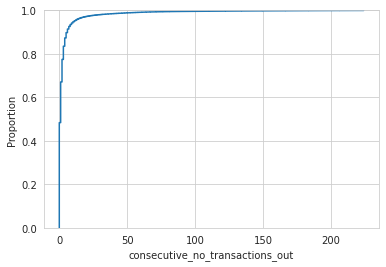

In [26]:
sns.ecdfplot(data=cluster_station[cluster_station['status'] == 1], 
            x='consecutive_no_transactions_out')

In [27]:
PROFILE_STATION_RULE[profile_station_activity]

36

In [28]:
cluster_station.shape

(83446, 26)

In [29]:
cluster_station.head(2)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
9591898,106,2018-12-01 00:10:00,18.0,20.0,1.0,0.0,0.0,0.0,0,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,0.381680,0.068976,-0.049947,1.089113,0.844565,0.867604,-0.441446,1
9591899,106,2018-12-01 00:20:00,15.0,23.0,1.0,3.0,0.0,3.0,1,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1.104432,0.087866,-0.005605,1.089719,0.802182,0.939407,0.242918,1


In [30]:
cluster_station.consecutive_no_transactions_out.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.98])

count    83446.000000
mean         2.464935
std         10.722953
min          0.000000
50%          0.000000
75%          2.000000
80%          2.000000
85%          3.000000
90%          4.000000
95%          9.000000
98%         22.000000
99%         45.000000
max        224.000000
Name: consecutive_no_transactions_out, dtype: float64

In [31]:
cluster_station.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
9591898,106,2018-12-01 00:10:00,18.0,20.0,1.0,0.0,0.0,0.0,0,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,0.381680,0.068976,-0.049947,1.089113,0.844565,0.867604,-0.441446,1
9591899,106,2018-12-01 00:20:00,15.0,23.0,1.0,3.0,0.0,3.0,1,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1.104432,0.087866,-0.005605,1.089719,0.802182,0.939407,0.242918,1
9591900,106,2018-12-01 00:30:00,14.0,24.0,1.0,1.0,0.0,1.0,2,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1.827184,0.106756,0.038738,1.090325,0.759799,1.011210,0.927281,1
9591901,106,2018-12-01 00:40:00,14.0,24.0,1.0,2.0,2.0,4.0,0,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,0.381680,0.068976,-0.049947,1.089113,0.844565,0.867604,-0.441446,1
9591902,106,2018-12-01 00:50:00,13.0,25.0,1.0,1.0,0.0,1.0,1,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1.104432,0.087866,-0.005605,1.089719,0.802182,0.939407,0.242918,1


In [32]:
# Graph
# Type date for better display in graph
cluster_station['date_str'] = cluster_station['date'].dt.strftime(date_format='%Y-%m-%d %H:%M')

fig = px.scatter(cluster_station, x='pca_1', y='pca_2', color='cluster', #'cluster_info'
                 hover_data=['date_str', 'available_bikes',
                             'weekday', 'hours', 'consecutive_no_transactions_out',
                             #'precipitation'
                             ]
                )
#fig.show()

# Drop non usefull columns
cluster_station = cluster_station.drop('date_str', axis=1)

In [33]:
#fig = px.scatter_3d(cluster_station, x='pca_4', y='pca_5', z='pca_1', color="consecutive_no_transactions_out",
#                    hover_data=['date_str', 'available_stands', 'available_stands',
#                             'weekday', 'hours', 'consecutive_no_transactions_out',
#                             'precipitation'],
#                    opacity=0.5,
#                    size_max=1,
#                    labels={'cluster': 'Anomaly'},
#                )#color_discrete_sequence=px.colors.qualitative.Set1)
#fig.show()

In [34]:
cluster_station.cluster.value_counts(normalize=True)

 1    0.988915
-1    0.011085
Name: cluster, dtype: float64

In [35]:
cluster_station[cluster_station['cluster'] == -1]

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,cluster
9620718,106,2019-06-19 03:30:00,8.0,19.0,1.0,0.0,0.0,0.0,28,2,2,3,1.224647e-16,-1.000000e+00,0.974928,-0.222521,0.707107,7.071068e-01,20.076686,0.497356,0.727347,0.568479,-1.595278,0.551621,19.493022,-1
9620719,106,2019-06-19 03:40:00,8.0,19.0,1.0,0.0,0.0,0.0,29,2,2,3,1.224647e-16,-1.000000e+00,0.974928,-0.222521,0.707107,7.071068e-01,20.799438,0.516246,0.771689,0.569085,-1.637661,0.623424,20.177386,-1
9620720,106,2019-06-19 03:50:00,8.0,19.0,1.0,0.0,0.0,0.0,30,2,2,3,1.224647e-16,-1.000000e+00,0.974928,-0.222521,0.707107,7.071068e-01,21.522191,0.535136,0.816031,0.569690,-1.680044,0.695228,20.861750,-1
9620721,106,2019-06-19 04:00:00,8.0,19.0,1.0,0.0,0.0,0.0,31,2,2,4,1.224647e-16,-1.000000e+00,0.974928,-0.222521,0.866025,5.000000e-01,22.319758,0.574461,0.839932,0.354651,-1.668368,0.677451,21.480800,-1
9620722,106,2019-06-19 04:10:00,8.0,19.0,1.0,0.0,0.0,0.0,32,2,2,4,1.224647e-16,-1.000000e+00,0.974928,-0.222521,0.866025,5.000000e-01,23.042510,0.593351,0.884274,0.355257,-1.710750,0.749254,22.165163,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683514,106,2020-08-28 05:30:00,9.0,31.0,1.0,0.0,0.0,0.0,50,3,4,5,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.965926,2.588190e-01,36.818295,0.489684,0.870482,0.222508,-1.787199,3.407038,33.638730,-1
9683515,106,2020-08-28 05:40:00,0.0,40.0,1.0,9.0,0.0,9.0,51,3,4,5,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.965926,2.588190e-01,37.541047,0.508573,0.914824,0.223114,-1.829581,3.478842,34.323093,-1
9683516,106,2020-08-28 05:50:00,0.0,40.0,1.0,0.0,0.0,0.0,52,3,4,5,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.965926,2.588190e-01,38.263800,0.527463,0.959166,0.223720,-1.871964,3.550645,35.007457,-1
9683517,106,2020-08-28 06:00:00,0.0,40.0,1.0,0.0,0.0,0.0,53,3,4,6,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,1.000000,6.123234e-17,39.004352,0.538369,1.015260,-0.034683,-1.899679,3.619375,35.673942,-1


In [36]:
cluster_station[cluster_station['cluster'] == -1]['consecutive_no_transactions_out'].describe()

count    925.000000
mean      84.280000
std       47.003713
min       21.000000
25%       51.000000
50%       66.000000
75%      109.000000
max      224.000000
Name: consecutive_no_transactions_out, dtype: float64

In [37]:
cluster_station['anomaly'] = cluster_station['cluster']

In [38]:
cluster_station[cluster_station['status'] == 0]['date'].nunique() / 6 / 24

128.49305555555557

<AxesSubplot:xlabel='cluster', ylabel='consecutive_no_transactions_out'>

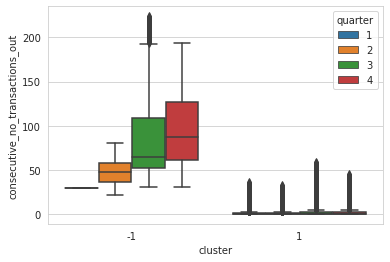

In [39]:
sns.boxplot(data=cluster_station, x='cluster', y='consecutive_no_transactions_out', hue='quarter')

In [40]:
cluster_station[cluster_station['cluster'] == -1].groupby('quarter')['cluster'].count()

quarter
1      1
2    140
3    463
4    321
Name: cluster, dtype: int64

In [41]:
# Lecture de profile des stations pour connaitre ceux que l'on clusterise
station_profile = read_station_profile(path_directory=ROOT_DATA_REF)

stations_id_to_fit = \
    station_profile[station_profile['mean'] >= THRESHOLD_PROFILE_STATION]['station_id'].unique()

# Filter station we don't want to use
stations_id_to_fit = [station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

In [42]:
[station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

[124,
 15,
 60,
 18,
 10,
 68,
 130,
 2,
 105,
 120,
 11,
 110,
 9,
 23,
 3,
 16,
 20,
 136,
 42,
 21,
 131,
 59,
 45,
 172,
 6,
 24,
 36,
 108,
 19,
 125,
 135,
 37,
 139,
 99,
 28,
 57,
 7,
 98,
 8,
 41,
 40,
 58,
 55,
 109,
 1,
 4,
 100,
 134,
 174,
 101,
 56,
 104,
 43,
 54,
 44,
 102,
 133,
 103,
 5,
 127,
 65,
 22,
 123,
 39,
 106]

In [43]:
%load_ext autoreload
%autoreload 2
from vcub_keeper.reader.reader_utils import filter_periode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
ts_activity.date.max()

Timestamp('2020-08-28 11:50:00')

In [45]:
station_id = 62

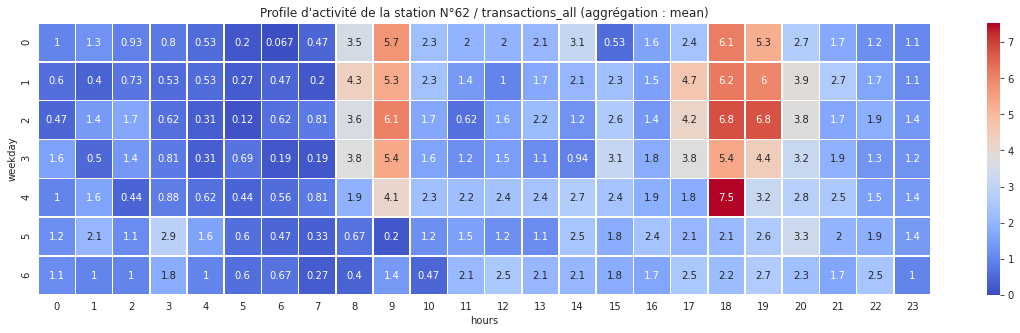

In [46]:
plot_profile_station(ts_activity[ts_activity['date'] >="2020-03-17"],
                     station_id=station_id, feature_to_plot='transactions_all',
                     aggfunc='mean', filter_data=True, vmin=0)

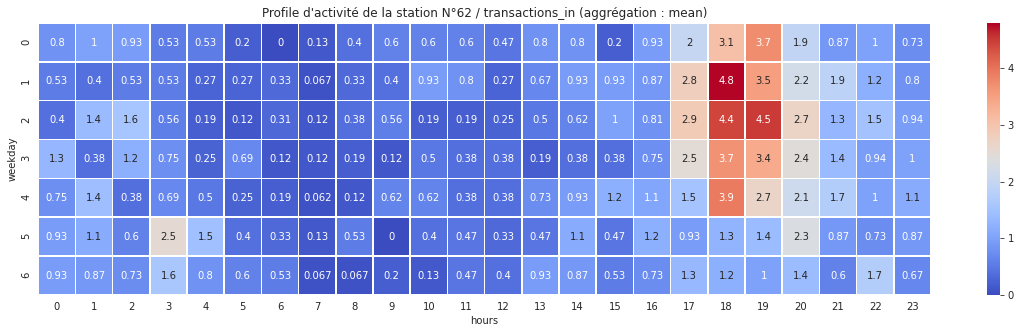

In [47]:
plot_profile_station(ts_activity[ts_activity['date'] >="2020-03-17"],
                     station_id=station_id, feature_to_plot='transactions_in',
                     aggfunc='mean', filter_data=True, vmin=0)

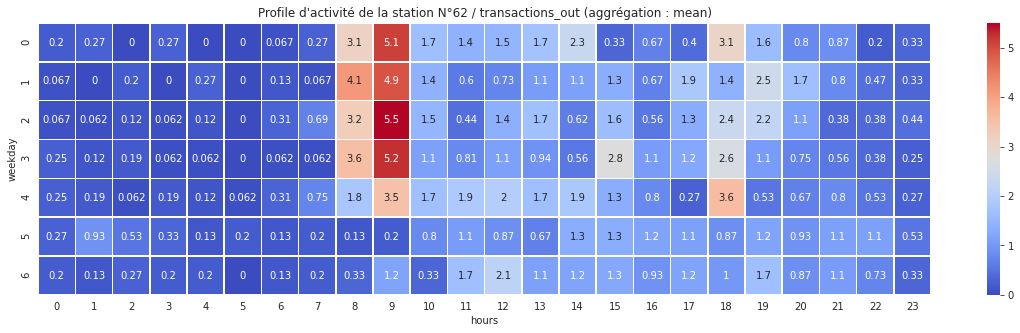

In [48]:
plot_profile_station(ts_activity[ts_activity['date'] >="2020-03-17"],
                     station_id=station_id, feature_to_plot='transactions_out',
                     aggfunc='mean', filter_data=True, vmin=0)

#### On compare par rapport au données post-covid

In [49]:
from vcub_keeper.production.data import get_data_from_api_by_station, transform_json_station_data_to_df

station_json = get_data_from_api_by_station(station_id=station_id,
                                            start_date="2021/09/04",
                                            stop_date="2021/11/18")

station_df = transform_json_station_data_to_df(station_json)

station_df = get_consecutive_no_transactions_out(station_df)

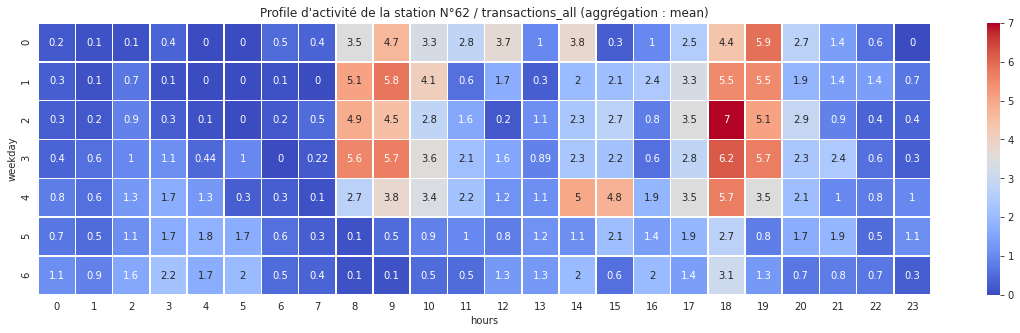

In [50]:
plot_profile_station(station_df, station_id=station_id, feature_to_plot='transactions_all',
                     aggfunc='mean', filter_data=True, vmin=0)

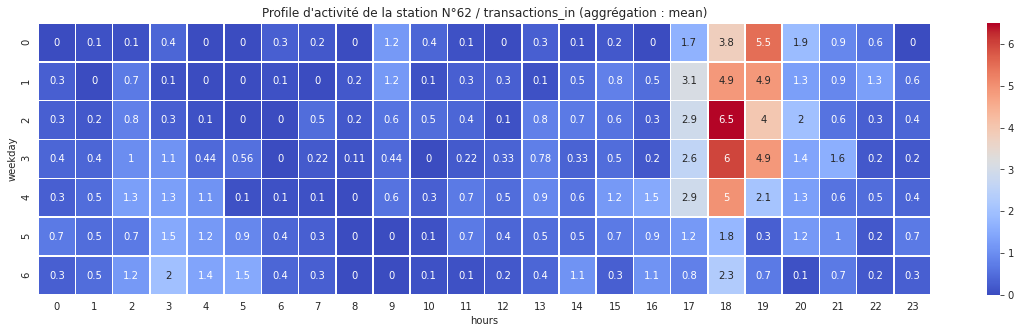

In [51]:
plot_profile_station(station_df, station_id=station_id, feature_to_plot='transactions_in',
                      aggfunc='mean', filter_data=True, vmin=0)

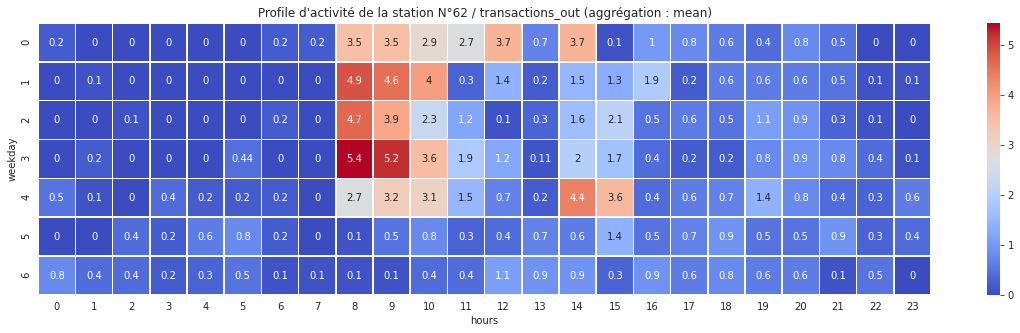

In [52]:
plot_profile_station(station_df, station_id=station_id, feature_to_plot='transactions_out',
                      aggfunc='mean', filter_data=True, vmin=0)

## Industrialisation

In [53]:
from vcub_keeper.config import *
from vcub_keeper.reader.reader import *
from vcub_keeper.reader.reader_utils import filter_periode
from vcub_keeper.visualisation import *
from vcub_keeper.transform.features_factory import *
from vcub_keeper.ml.cluster import (train_cluster_station, predict_anomalies_station,
                                    logistic_predict_proba_from_model)
from vcub_keeper.ml.cluster_utils import load_model, export_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
#ts_activity = get_transactions_in(ts_activity)
#ts_activity = get_transactions_out(ts_activity)
#ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)

In [55]:
station_id = 106

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from scipy import stats
def train_cluster_station(data, station_id):
    """
    Train estimator on a single station_id Time Serie.
    Process some features.
    Filter data based on filter_periode() function.
    Filter data based on status = 1.
    Use sclaler / pca / IsolationForest (contamination based on PROFILE_STATION_RULE).
    contamination is based on station profile (from read_station_profile() ).
    
    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    station_id : int
        ID Station
    
    Returns
    -------
    clf : Pipeline
        Pipeline Scikit Learn
        
    Examples
    --------
    clf = train_cluster_station(data=ts_activity, station_id=110)
    """

    # Filter stations
    data_station = data[data['station_id'] == station_id].copy()
    
    # Feature engi for cluster
    data_station = process_data_cluster(data_station)

    # Filter data based on time & event
    data_station = filter_periode(data_station, NON_USE_STATION_ID=NON_USE_STATION_ID)
    
    # on prend uniquement la station quand satus ==1
    data_station_ok = data_station[(data_station['status'] == 1) & 
                                   (data_station['consecutive_no_transactions_out'] <= 144)].copy()

    # Lecture du profile activité des stations
    station_profile = read_station_profile(path_directory=ROOT_DATA_REF)
    profile_station_activity = \
        station_profile[station_profile['station_id'] == station_id]['profile_station_activity'].values[0]

    print('Profile de la station N°' + str(station_id) + ' : ' + profile_station_activity)

    # Scaler
    clf_scaler = StandardScaler()

    # Cluster
    contaminsation_station = \
        1 - stats.percentileofscore(data_station_ok['consecutive_no_transactions_out'],
                                    PROFILE_STATION_RULE[profile_station_activity]) / 100
    print('Contamination de la station : ' + str(contaminsation_station))
    
    clf_cluster = IsolationForest(n_estimators=50, random_state=SEED,n_jobs=-1,
                                  # Use of bootstrap
                                  # https://datascience.stackexchange.com/questions/94348/the-affect-of-bootstrap-on-isolation-forest
                                  #bootstrap=True,
                                  contamination=contaminsation_station)
    
    # Learning
    pipe = Pipeline([
        ('scale', clf_scaler),
        ('pca', PCA(n_components=0.95)),
        ('cluster', clf_cluster)])
    pipe.fit(data_station_ok[FEATURES_TO_USE_CLUSTER])

    return pipe

#from vcub_keeper.ml.cluster import train_cluster_station

clf = train_cluster_station(ts_activity, station_id=station_id)
#  0.004647817613759431

Profile de la station N°106 : very high
Contamination de la station : 0.014240970175736334


In [57]:
# Faire une prédiction d'une station
station_pred = predict_anomalies_station(data=ts_activity, clf=clf, station_id=station_id)

In [58]:
station_pred['consecutive_no_transactions_out'].describe()

count    91655.000000
mean         3.692717
std         12.358139
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        224.000000
Name: consecutive_no_transactions_out, dtype: float64

In [59]:
#bootstrap=False
station_pred.anomaly.value_counts()

 1    88975
-1     2680
Name: anomaly, dtype: int64

In [60]:
#bootstrap=False
station_pred.anomaly.value_counts(normalize=True)

 1    0.97076
-1    0.02924
Name: anomaly, dtype: float64

In [61]:
station_pred['quarter'] = station_pred['date'].dt.quarter
station_pred[station_pred['anomaly'] == -1].groupby('quarter')['anomaly'].count()

quarter
1     407
2    1369
3     564
4     340
Name: anomaly, dtype: int64

In [62]:
#station_pred[station_pred['anomaly'] == -1]

In [63]:
# Score anomaly
station_pred['anomaly_score'] = \
        logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER])) * 100

In [64]:
station_pred[(station_pred['anomaly'] == -1) & (station_pred['consecutive_no_transactions_out'] < 36)].sort_values('consecutive_no_transactions_out')

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score
9665641,106,2020-04-26 02:40:00,18.0,22.0,1.0,0.0,0.0,0.0,20,2,6,2,1.224647e-16,-1.000000e+00,-0.781831,0.623490,5.000000e-01,8.660254e-01,-1,51.388210
9667515,106,2020-05-09 03:00:00,12.0,28.0,1.0,0.0,0.0,0.0,20,2,5,3,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,7.071068e-01,7.071068e-01,-1,58.859936
9666639,106,2020-05-03 01:00:00,9.0,31.0,1.0,0.0,0.0,0.0,21,2,6,1,1.224647e-16,-1.000000e+00,-0.781831,0.623490,2.588190e-01,9.659258e-01,-1,53.348411
9662878,106,2020-04-06 22:10:00,11.0,29.0,1.0,0.0,0.0,0.0,21,2,0,22,1.224647e-16,-1.000000e+00,0.000000,1.000000,-5.000000e-01,8.660254e-01,-1,52.116450
9665642,106,2020-04-26 02:50:00,18.0,22.0,1.0,0.0,0.0,0.0,21,2,6,2,1.224647e-16,-1.000000e+00,-0.781831,0.623490,5.000000e-01,8.660254e-01,-1,54.503298
9661605,106,2020-03-29 02:00:00,21.0,19.0,1.0,0.0,0.0,0.0,21,1,6,2,1.000000e+00,6.123234e-17,-0.781831,0.623490,5.000000e-01,8.660254e-01,-1,56.849310
9660595,106,2020-03-22 01:40:00,14.0,26.0,1.0,0.0,0.0,0.0,21,1,6,1,1.000000e+00,6.123234e-17,-0.781831,0.623490,2.588190e-01,9.659258e-01,-1,50.670856
9662607,106,2020-04-05 01:00:00,15.0,25.0,1.0,0.0,0.0,0.0,21,2,6,1,1.224647e-16,-1.000000e+00,-0.781831,0.623490,2.588190e-01,9.659258e-01,-1,53.348411
9667516,106,2020-05-09 03:10:00,12.0,28.0,1.0,0.0,0.0,0.0,21,2,5,3,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,7.071068e-01,7.071068e-01,-1,59.612621
9665905,106,2020-04-27 22:40:00,15.0,25.0,1.0,0.0,0.0,0.0,21,2,0,22,1.224647e-16,-1.000000e+00,0.000000,1.000000,-5.000000e-01,8.660254e-01,-1,52.116450


In [65]:
station_pred['decision_function'] = \
    np.abs(clf.score_samples(station_pred[FEATURES_TO_USE_CLUSTER]))


station_pred['score_samples'] = - clf.score_samples(station_pred[FEATURES_TO_USE_CLUSTER])

In [66]:
station_pred.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score,decision_function,score_samples
9591898,106,2018-12-01 00:10:00,18.0,20.0,1.0,0.0,0.0,0.0,0,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1,17.309081,0.479020,0.479020
9591899,106,2018-12-01 00:20:00,15.0,23.0,1.0,3.0,0.0,3.0,1,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1,16.939520,0.477718,0.477718
9591900,106,2018-12-01 00:30:00,14.0,24.0,1.0,1.0,0.0,1.0,2,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1,17.122330,0.478365,0.478365
9591901,106,2018-12-01 00:40:00,14.0,24.0,1.0,2.0,2.0,4.0,0,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1,17.309081,0.479020,0.479020
9591902,106,2018-12-01 00:50:00,13.0,25.0,1.0,1.0,0.0,1.0,1,4,5,0,-2.449294e-16,1.0,-0.974928,-0.222521,0.0,1.0,1,16.939520,0.477718,0.477718


In [67]:
station_pred[station_pred['anomaly'] == -1]['anomaly_score'].describe()

count    2680.000000
mean       73.892355
std        14.270937
min        50.050529
25%        61.113955
50%        73.228362
75%        85.389596
max        98.423835
Name: anomaly_score, dtype: float64

In [68]:
# On essaye de produire des probabilité à partir du score d'anomaly d'Iosaltion Forest
# OLD
# CF https://stackoverflow.com/a/69577241

from scipy.special import erf

def convert_probabilities(data, model):
    decision_scores = - model.decision_function(data)
    probs = np.zeros([data.shape[0], 2 ])#int(model.classes)])
    pre_erf_score = (decision_scores - np.mean(decision_scores) ) / ( np.std(decision_scores) * np.sqrt(2) )
    erf_score = erf(pre_erf_score)
    probs[:, 1] = erf_score.clip(0, 1).ravel()
    probs[:, 0] = 1 - probs[:, 1]
    return probs[:, 1]

#station_pred['anoamlie_score_scale_2'] = convert_probabilities(station_pred[FEATURES_TO_USE_CLUSTER],
#                                                               clf) * 100

In [69]:
station_pred[station_pred['anomaly'] == -1].groupby('quarter')['anomaly_score'].describe()

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
1,407.0,64.000337,9.770416,50.050529,56.635840,62.367038,70.809147,91.216088
2,1369.0,71.956585,12.062526,50.166451,60.774579,73.196357,82.550573,94.488292
3,564.0,77.526472,15.594630,50.178082,63.447301,77.022139,94.892833,98.423835
4,340.0,87.499644,12.797638,51.131058,81.825766,93.237226,97.171238,97.984573


In [70]:
station_pred[station_pred['anomaly'] == 1].groupby('quarter')['anomaly_score'].describe()

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
1,25657.0,14.187672,4.634677,7.311837,11.594584,13.781779,15.888520,49.856867
2,24839.0,15.810487,5.393957,8.697678,12.464565,14.694488,17.455501,49.999138
3,21108.0,14.200076,4.747226,6.590577,11.375636,13.229612,16.363713,49.957722
4,17371.0,18.695569,5.515271,7.132492,14.794776,17.834474,21.416159,49.087987


In [71]:
max_value = station_pred['consecutive_no_transactions_out'].max()
station_pred['anomaly_display'] = 0
station_pred.loc[station_pred['anomaly'] == -1,
                'anomaly_display'] = 100#max_value

#plot_station_activity(station_pred,
#                      features_to_plot=['consecutive_no_transactions_out',
#                                        'anomaly_display',
#                                        'anomaly_score'
#                                       ],
#                      station_id=station_id)

In [72]:
# Export model
#export_model(clf, station_id=station_id, path_directory=ROOT_MODEL)

In [73]:
# Chargement model
#clf = load_model(station_id=station_id)

In [74]:
# Analyser données graphique à partir d'une date
#station_pred[station_pred.date >= "2019-04-16 11:10:00"].head(80)
station_pred

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly,anomaly_score,decision_function,score_samples,anomaly_display
9591898,106,2018-12-01 00:10:00,18.0,20.0,1.0,0.0,0.0,0.0,0,4,5,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.000000,1.000000,1,17.309081,0.479020,0.479020,0
9591899,106,2018-12-01 00:20:00,15.0,23.0,1.0,3.0,0.0,3.0,1,4,5,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.000000,1.000000,1,16.939520,0.477718,0.477718,0
9591900,106,2018-12-01 00:30:00,14.0,24.0,1.0,1.0,0.0,1.0,2,4,5,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.000000,1.000000,1,17.122330,0.478365,0.478365,0
9591901,106,2018-12-01 00:40:00,14.0,24.0,1.0,2.0,2.0,4.0,0,4,5,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.000000,1.000000,1,17.309081,0.479020,0.479020,0
9591902,106,2018-12-01 00:50:00,13.0,25.0,1.0,1.0,0.0,1.0,1,4,5,0,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.000000,1.000000,1,16.939520,0.477718,0.477718,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683548,106,2020-08-28 11:10:00,20.0,20.0,1.0,8.0,10.0,8.0,0,3,4,11,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926,1,11.040207,0.452882,0.452882,0
9683549,106,2020-08-28 11:20:00,20.0,20.0,1.0,0.0,0.0,0.0,1,3,4,11,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926,1,11.085999,0.453115,0.453115,0
9683550,106,2020-08-28 11:30:00,20.0,20.0,1.0,0.0,0.0,0.0,2,3,4,11,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926,1,11.356049,0.454470,0.454470,0
9683551,106,2020-08-28 11:40:00,20.0,20.0,1.0,0.0,0.0,0.0,3,3,4,11,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.258819,-0.965926,1,11.356049,0.454470,0.454470,0


In [75]:
# Pour le language des dates sur le graphique
# NE MARCHE PAS
#import locale

#locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8') 

#ts_activity.head().date.dt.strftime('%a %Y-%m-%d %H:%M') # MARCHE SUR PANDAS

In [76]:
#start_date = "2019-01-01" 
#end_date = "2019-01-06"

#plott = plot_station_anomalies_with_score(data=station_pred, clf=clf,
#                              station_id=station_id,
#                              #start_date=start_date,
#                              #end_date=start_date,
#                              return_data=True,
#                              offline_plot=False,
#                              return_plot=False
#                                         )

In [77]:
fig = px.scatter(x=clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]),
                 y=logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]),
                                                                           k=20))
#fig.show()

<AxesSubplot:ylabel='Proportion'>

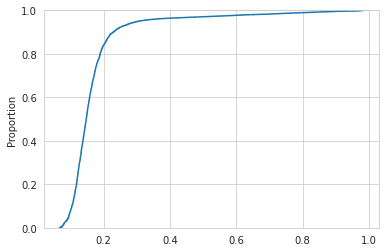

In [78]:
#fig = px.ecdf(decision_function)
sns.ecdfplot(logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]),
                                                                           k=20))

In [79]:
logistic_predict_proba_from_model(-0.182787, k=20)

0.9748086373851281

In [80]:
logistic_predict_proba_from_model(0.15, k=20)

0.04742587317756678

### Analyse du score d'anomalie pour un trimestre différent

In [81]:
test_saison = [{'station_id': station_id,
 'date': pd.Timestamp('2019-01-05 09:40:00'),
 'consecutive_no_transactions_out': 38},
{'station_id': station_id,
 'date': pd.Timestamp('2019-04-06 09:40:00'),
 'consecutive_no_transactions_out': 38},
{'station_id': station_id,
 'date': pd.Timestamp('2019-07-06 09:40:00'),
 'consecutive_no_transactions_out': 38},
{'station_id': station_id,
 'date': pd.Timestamp('2019-10-05 09:40:00'),
 'consecutive_no_transactions_out': 38}]

test_saison_df = pd.DataFrame(test_saison)
test_saison_df

,station_id,date,consecutive_no_transactions_out
0,106,2019-01-05 09:40:00,38
1,106,2019-04-06 09:40:00,38
2,106,2019-07-06 09:40:00,38
3,106,2019-10-05 09:40:00,38


In [82]:
test_saison_df_build = process_data_cluster(test_saison_df)
test_saison_df_build

,station_id,date,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours
0,106,2019-01-05 09:40:00,38,1,5,9,1.000000e+00,6.123234e-17,-0.974928,-0.222521,0.707107,-0.707107
1,106,2019-04-06 09:40:00,38,2,5,9,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,0.707107,-0.707107
2,106,2019-07-06 09:40:00,38,3,5,9,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.707107,-0.707107
3,106,2019-10-05 09:40:00,38,4,5,9,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.707107,-0.707107


In [83]:
test_saison_df_build['anomaly_score'] = \
        logistic_predict_proba_from_model(clf.decision_function(test_saison_df_build[FEATURES_TO_USE_CLUSTER])) * 100
test_saison_df_build

,station_id,date,consecutive_no_transactions_out,quarter,weekday,hours,Sin_quarter,Cos_quarter,Sin_weekday,Cos_weekday,Sin_hours,Cos_hours,anomaly_score
0,106,2019-01-05 09:40:00,38,1,5,9,1.000000e+00,6.123234e-17,-0.974928,-0.222521,0.707107,-0.707107,54.724414
1,106,2019-04-06 09:40:00,38,2,5,9,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,0.707107,-0.707107,64.770465
2,106,2019-07-06 09:40:00,38,3,5,9,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,0.707107,-0.707107,40.797067
3,106,2019-10-05 09:40:00,38,4,5,9,-2.449294e-16,1.000000e+00,-0.974928,-0.222521,0.707107,-0.707107,43.591177


In [84]:
test_saison_df_build[['station_id', 'date', 'quarter',
                      'weekday', 'consecutive_no_transactions_out', 'anomaly_score']]

,station_id,date,quarter,weekday,consecutive_no_transactions_out,anomaly_score
0,106,2019-01-05 09:40:00,1,5,38,54.724414
1,106,2019-04-06 09:40:00,2,5,38,64.770465
2,106,2019-07-06 09:40:00,3,5,38,40.797067
3,106,2019-10-05 09:40:00,4,5,38,43.591177


In [85]:
filter_periode(station_pred, NON_USE_STATION_ID=NON_USE_STATION_ID).groupby('quarter').size()

quarter
1    23904
2    20159
3    21672
4    17711
dtype: int64